# **Visión Global de las Energías Renovables**
<br>
<center><img src=go.jpg></center>

### Tipos de energía que trataremos:
 🌬️*Eólica* 

 🌻*Geotérmica/Biocombustibles* 
   
 🌊*Hidraúlica* 
                 
 🌞*Solar*                                                       
                                
#### Leyenda de los datasets empleados:
* `Entity`: país
* `Code`: codigo asignado mediante ISO 3 (viene en el dataset de la fuente, si no se dispone se puede generar mediante pycountry) 
* `Year`: Año de los datos
* `Electricity from wind (TWh)`: electricidad obtenida a partir de energía eólica
* `Electricity from hydro (TWh)`:electricidad obtenida a partir de saltos de agua en presas o de origen mareomotriz.
* `Electricity from solar (TWh)`:electricidad obtenida a partir de energía solar fotovoltaica o térmica.
* `Electricity from other renewables including bioenergy (TWh)`: electricidad obtenida por biomasa principalmente
* `Total Energy TWh`: suma de los terwatios por hora producidos por las 4 fuentes mencionadas
* `Wind Generation - TWh`: electricidad consumida de origen eólico
* `Solar Generation - TWh`: electricidad consumida de origen solar
* `Geo Biomass Other - TWh`: electricidad consumida de origen geotérmico/biomasa
* `Hydro Generation - TWh`: electricidad consumida originada por movimientos de agua.
* `Renewables (% sub energy)`:energía renovable residual consumida
* `Renewables (% electricity)`: energía renovable producida



#### Librerías y archivos csv empleados

In [207]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.express as px
%matplotlib inline

from datetime import datetime
from matplotlib import pyplot as plot_acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
 
import geopandas as gpd

import warnings
warnings.filterwarnings('ignore')




In [208]:
consum = pd.read_csv('modern-renewable-energy-consumption.csv')
prod = pd.read_csv('modern-renewable-prod.csv')
share = pd.read_csv('renewable-share-energy.csv')
share_elec =pd.read_csv('share-electricity-renewables.csv')

### Tratamiento de los datasets
#### Elimino las columnas no representativas (con más de un 80% de nulos)

In [209]:
def eliminar_columnas(df):

# Remove columns in dataframe whit null values more than 80%, u can change the value df.shape[0]*0.8 to change the percentage.
# remember inplace=True to aply the changes in the original dataframe.
    for col in df.columns:
        if df[col].isnull().sum() > df.shape[0]*0.8:
            df.drop(col, axis=1, inplace=True)
    return df

In [210]:
eliminar_columnas(consum)
eliminar_columnas(prod)
eliminar_columnas(share)
eliminar_columnas(share_elec)

,Entity,Code,Year,Renewables (% electricity)
0,Afghanistan,AFG,2000,65.957
1,Afghanistan,AFG,2001,84.746
2,Afghanistan,AFG,2002,81.159
3,Afghanistan,AFG,2003,67.021
4,Afghanistan,AFG,2004,62.921
...,...,...,...,...
6369,Zimbabwe,ZWE,2016,48.680
6370,Zimbabwe,ZWE,2017,58.276
6371,Zimbabwe,ZWE,2018,59.146
6372,Zimbabwe,ZWE,2019,67.639


#### Tratamiento de los valores nulos

In [211]:
def repair_null(df):
    
    #Repair null values in dataframe using mode if the column is categorical or mean if the column is numerical.
    
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df

In [212]:
repair_null(consum)
repair_null(prod)
repair_null(share)
repair_null(share_elec)

,Entity,Code,Year,Renewables (% electricity)
0,Afghanistan,AFG,2000,65.957
1,Afghanistan,AFG,2001,84.746
2,Afghanistan,AFG,2002,81.159
3,Afghanistan,AFG,2003,67.021
4,Afghanistan,AFG,2004,62.921
...,...,...,...,...
6369,Zimbabwe,ZWE,2016,48.680
6370,Zimbabwe,ZWE,2017,58.276
6371,Zimbabwe,ZWE,2018,59.146
6372,Zimbabwe,ZWE,2019,67.639


#### Filtros para eliminar datos colectivos
##### Pueden diluir las proporciones de las producciones y los consumos

In [213]:
# Filtro por las filas que contienen datos totales de producción de energía del mundo:
prod = prod[~prod.Entity.str.startswith('World')]
prod = prod[~prod.Entity.str.startswith('OECD')]
prod = prod[~prod.Entity.str.startswith('CIS')]
prod = prod[~prod.Entity.str.startswith('G20')]
prod = prod[~prod.Entity.str.startswith('G7')]
# Elimino el 2021 pues fue el último año en el que tomaron datos y no está completo.
prod = prod.drop(prod[prod['Year']==2021].index)

# Filtro por las filas que contienen datos totales de producción de energía eléctrica del mundo:
share_elec = share_elec[~share_elec.Entity.str.startswith('World')]
share_elec = share_elec[~share_elec.Entity.str.startswith('OECD')]
share_elec = share_elec[~share_elec.Entity.str.startswith('CIS')]
share_elec = share_elec[~share_elec.Entity.str.startswith('G20')]
share_elec = share_elec[~share_elec.Entity.str.startswith('G7')]
share_elec = share_elec.drop(share_elec[share_elec['Year']==2021].index)

# Filtro por las filas que contienen datos totales de consumo de energía del mundo:
consum = consum[~consum.Entity.str.startswith('World')]
consum = consum[~consum.Entity.str.startswith('OECD')]
consum = consum[~consum.Entity.str.startswith('CIS')]
consum = consum.drop(consum[consum['Year']==2021].index)

# Filtro por las filas que contienen datos totales de consumo de energía del mundo:
share = share[~share.Entity.str.startswith('World')]
share = share[~share.Entity.str.startswith('OECD')]
share = share[~share.Entity.str.startswith('CIS')]
share = share.drop(share[share['Year']==2021].index)


In [214]:
# Me aseguro que no quedan nulos
prod.isnull().sum()

Entity                                                         0
Code                                                           0
Year                                                           0
Electricity from wind (TWh)                                    0
Electricity from hydro (TWh)                                   0
Electricity from solar (TWh)                                   0
Electricity from other renewables including bioenergy (TWh)    0
dtype: int64

### 1. Consumo de energía en el mundo


In [215]:
# Tipos de energía consumida en el último año que tenemos registro global 2020
# Filtro por año
cons20 = consum.loc[consum['Year']==2020,:]
cons20.drop(['Year'],axis=1,inplace = True)
cons20.drop(['Code'],axis=1,inplace = True)


##### 1.1 Correlación entre los tipos de energías implicados en el consumo

In [216]:
# Como nos pide la relación existente entre todas las columnas,
# no tenemos la certeza de que sea una distribución Gaussiana,
# Usamos Kendall por robustez y presencia de outliers 
# para tener una visión general
consum.corr('kendall')

,Year,Wind Generation - TWh,Solar Generation - TWh,Geo Biomass Other - TWh,Hydro Generation - TWh
Year,1.000000,0.544434,0.585357,0.312778,0.080520
Wind Generation - TWh,0.544434,1.000000,0.715006,0.542401,0.267428
Solar Generation - TWh,0.585357,0.715006,1.000000,0.467943,0.214104
Geo Biomass Other - TWh,0.312778,0.542401,0.467943,1.000000,0.452678
Hydro Generation - TWh,0.080520,0.267428,0.214104,0.452678,1.000000


<AxesSubplot: >

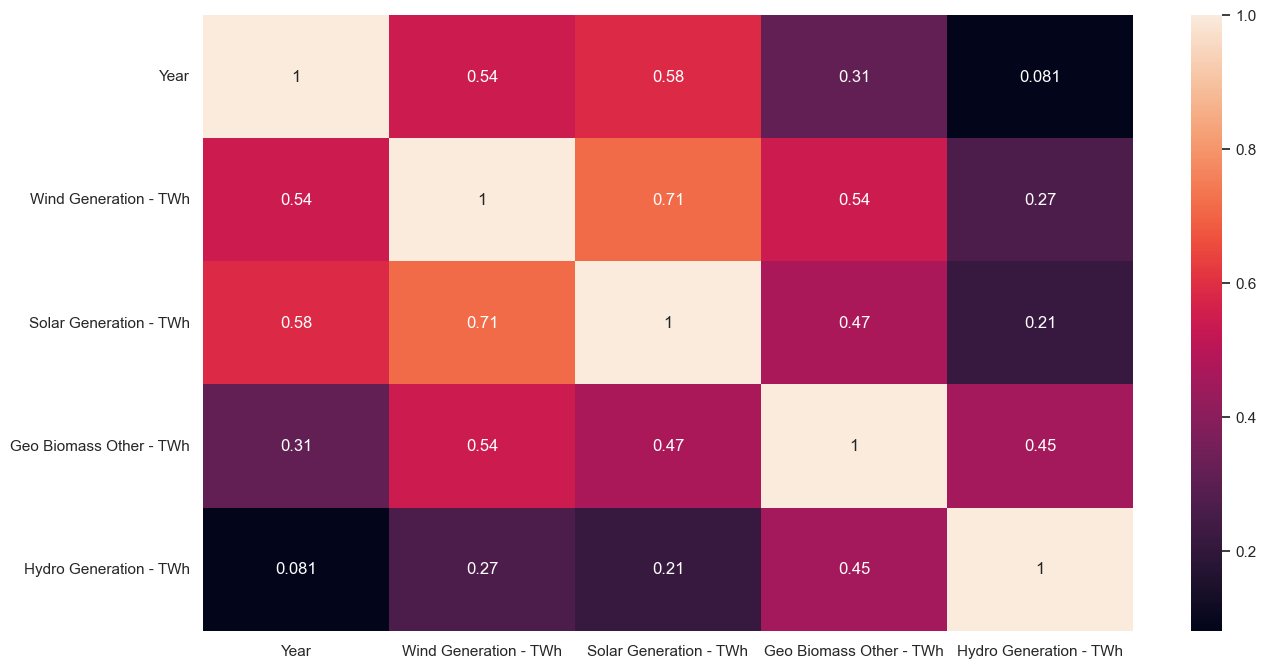

In [217]:
# Grafico correlaciones metodo Kendall
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(consum.corr('kendall').round(3),annot = True)

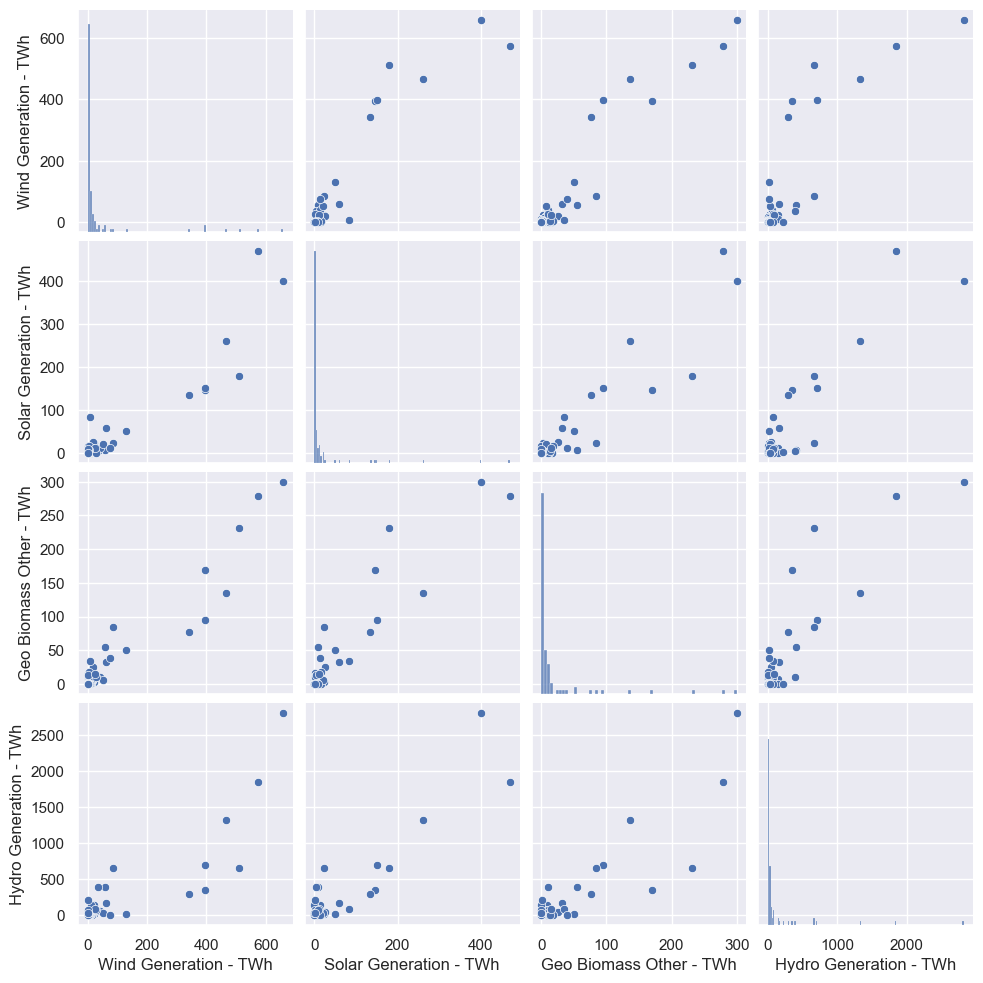

In [218]:
# Pairplot de las variables de nuestras muestras
cols = cons20[['Wind Generation - TWh', 'Solar Generation - TWh', 'Geo Biomass Other - TWh', 'Hydro Generation - TWh']]
sns.pairplot(cols, diag_kind="hist")

### 2. Producción de energía en el mundo

In [219]:
# Tipos de energía producida en el último año que tenemos registro a nivel global
# Filtramos por el año
prod20 = prod.loc[prod['Year']==2020,:]
prod20.drop('Year', axis=1, inplace=True)
prod20.drop(['Code'],axis=1,inplace = True)

##### 2.1 Correlación entre los tipos de energías implicados en la producción

In [220]:
prod.corr('kendall')

,Year,Electricity from wind (TWh),Electricity from hydro (TWh),Electricity from solar (TWh),Electricity from other renewables including bioenergy (TWh)
Year,1.000000,0.296590,-0.099798,0.400509,0.105421
Electricity from wind (TWh),0.296590,1.000000,0.309445,0.616678,0.531387
Electricity from hydro (TWh),-0.099798,0.309445,1.000000,0.250233,0.479997
Electricity from solar (TWh),0.400509,0.616678,0.250233,1.000000,0.434429
Electricity from other renewables including bioenergy (TWh),0.105421,0.531387,0.479997,0.434429,1.000000


<AxesSubplot: >

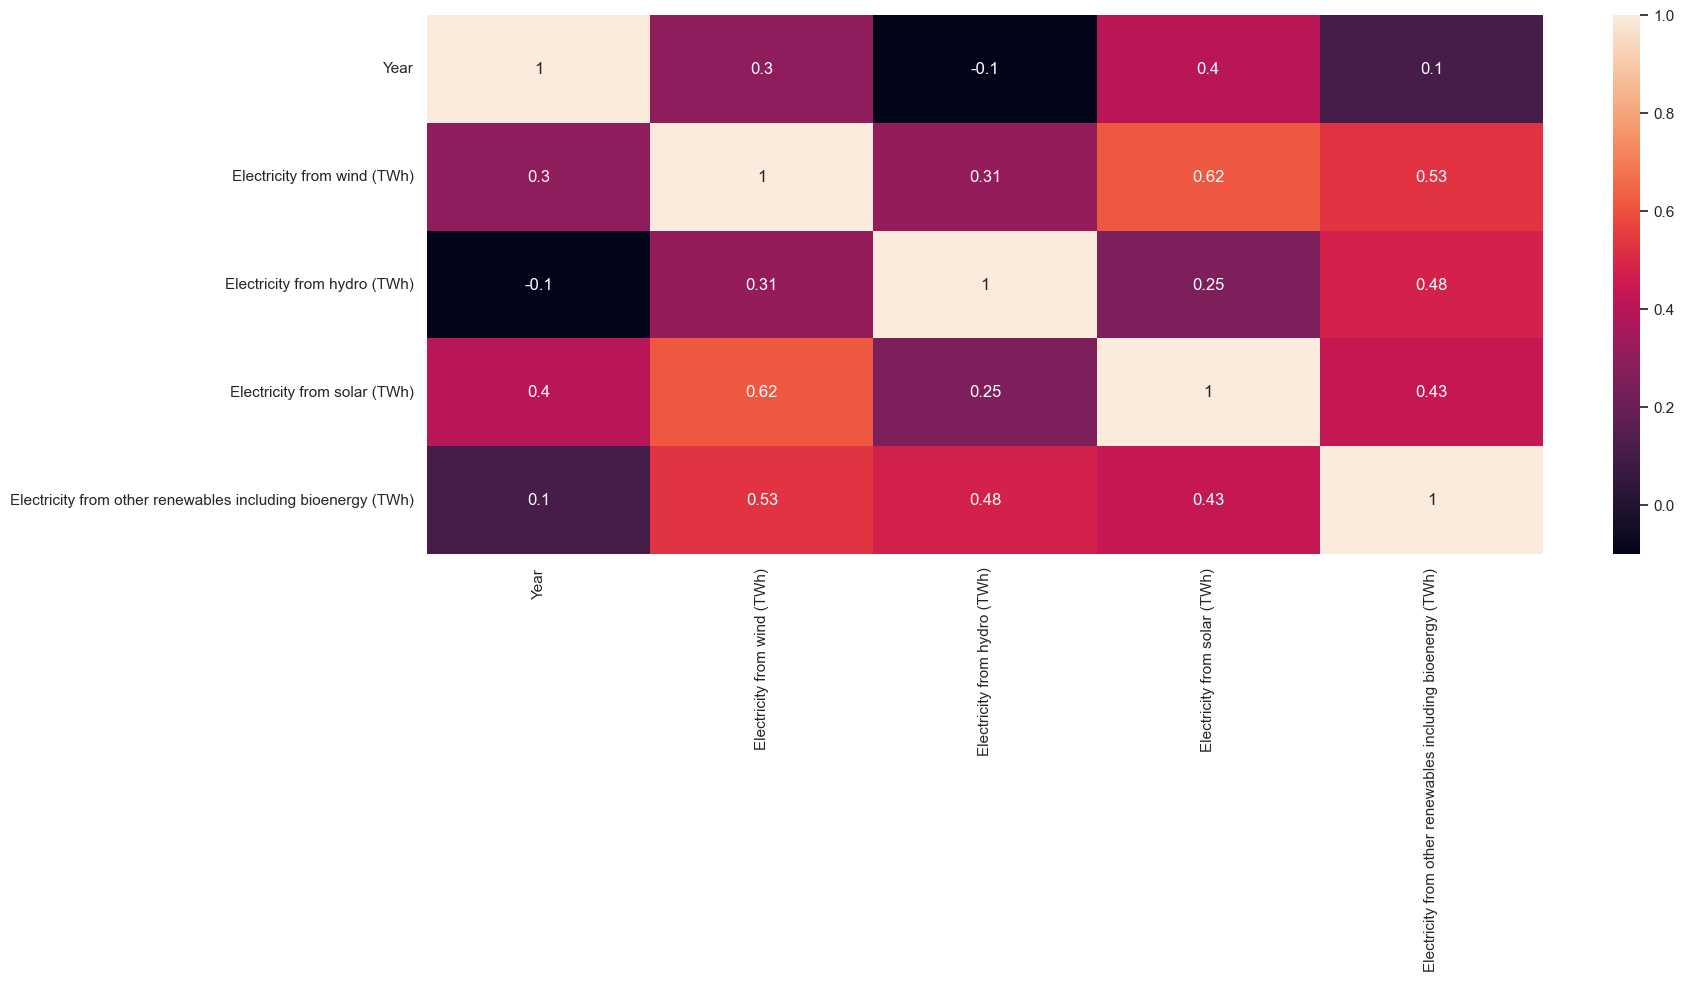

In [221]:
# Grafico correlaciones metodo Kendall

sns.set(rc = {'figure.figsize':(18,7)})
sns.heatmap(prod.corr('kendall').round(3),annot = True)

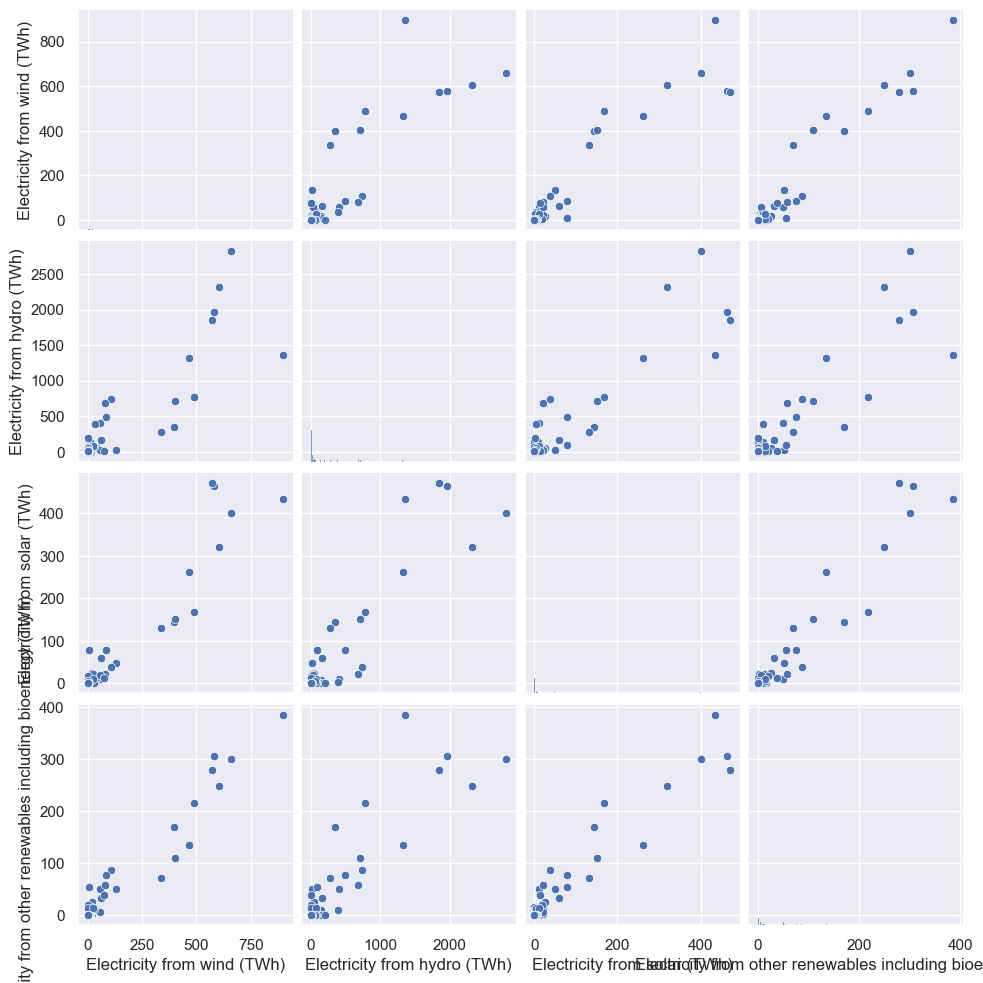

In [222]:
# Pairplot de las variables de nuestras muestras
sns.set(rc = {'figure.figsize':(18,7)})
cols = prod20[['Electricity from wind (TWh)', 'Electricity from hydro (TWh)', 'Electricity from solar (TWh)', 'Electricity from other renewables including bioenergy (TWh)']]
sns.pairplot(cols, diag_kind="hist")

#### 3. Consumo renovables en términos eléctricos por paises

<Figure size 1500x1000 with 0 Axes>

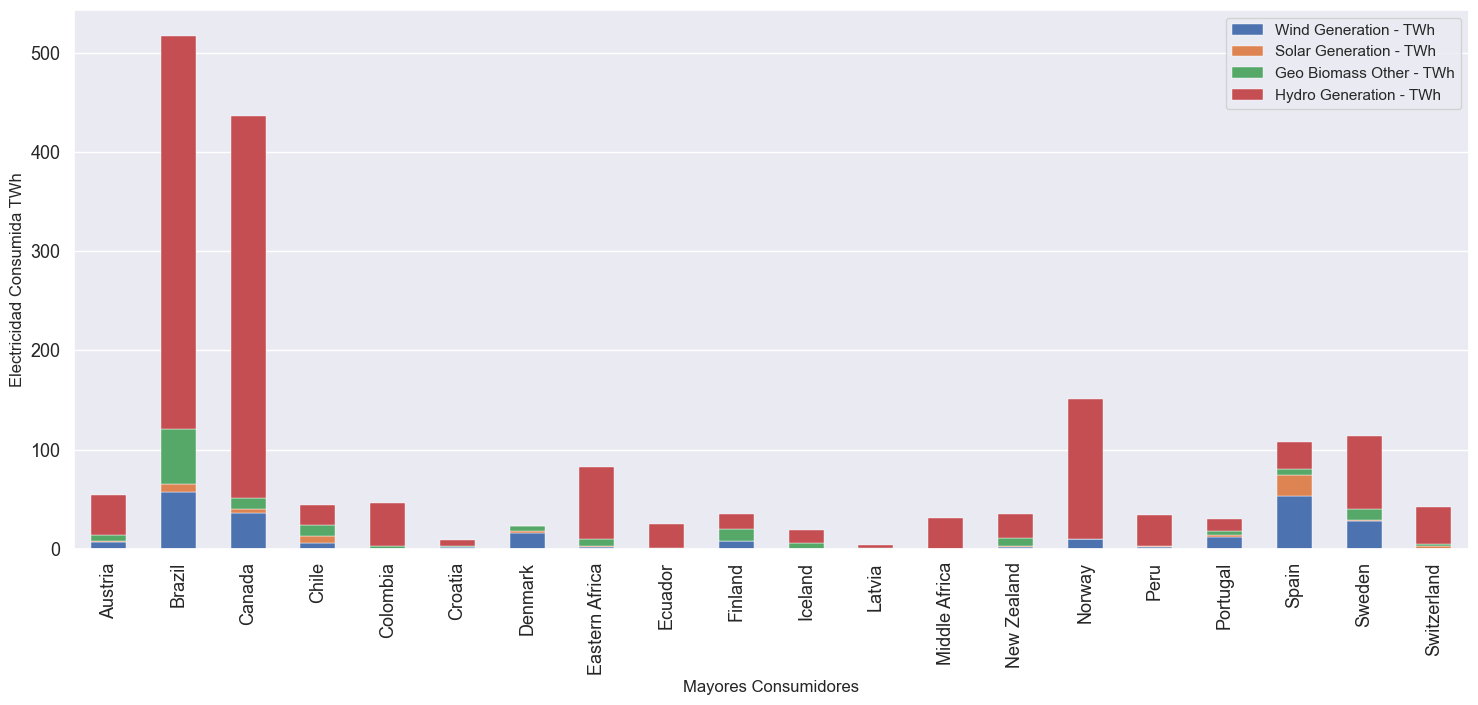

In [223]:
# Consumo eléctrico por países
# Filtro por el año
share20 = share.loc[share['Year']==2020,:]
# Saco la lista del top 20 de paises por consumo eléctrico
country_list_c = share20.sort_values(['Renewables (% sub energy)'],ascending=False).head(20)
# Cruzamos la lista del top de consumidores eléctricos con consumos por energía 
# para ver las qué paises y que energías son las más consumidas (durante el 2020)
cons20_all =pd.DataFrame(cons20[cons20['Entity'].isin(country_list_c['Entity'])])

# Grafico consumos energéticos por países
plt.figure(figsize=(15,10))
cons20_all.iloc[0:20].plot.bar(x='Entity',xlabel='Mayores Consumidores',ylabel='Electricidad Consumida TWh', linewidth=0.3, fontsize=13,stacked=True).grid(axis='x')

#### 4. Producción renovables en términos eléctricos por paises

<Figure size 1500x1000 with 0 Axes>

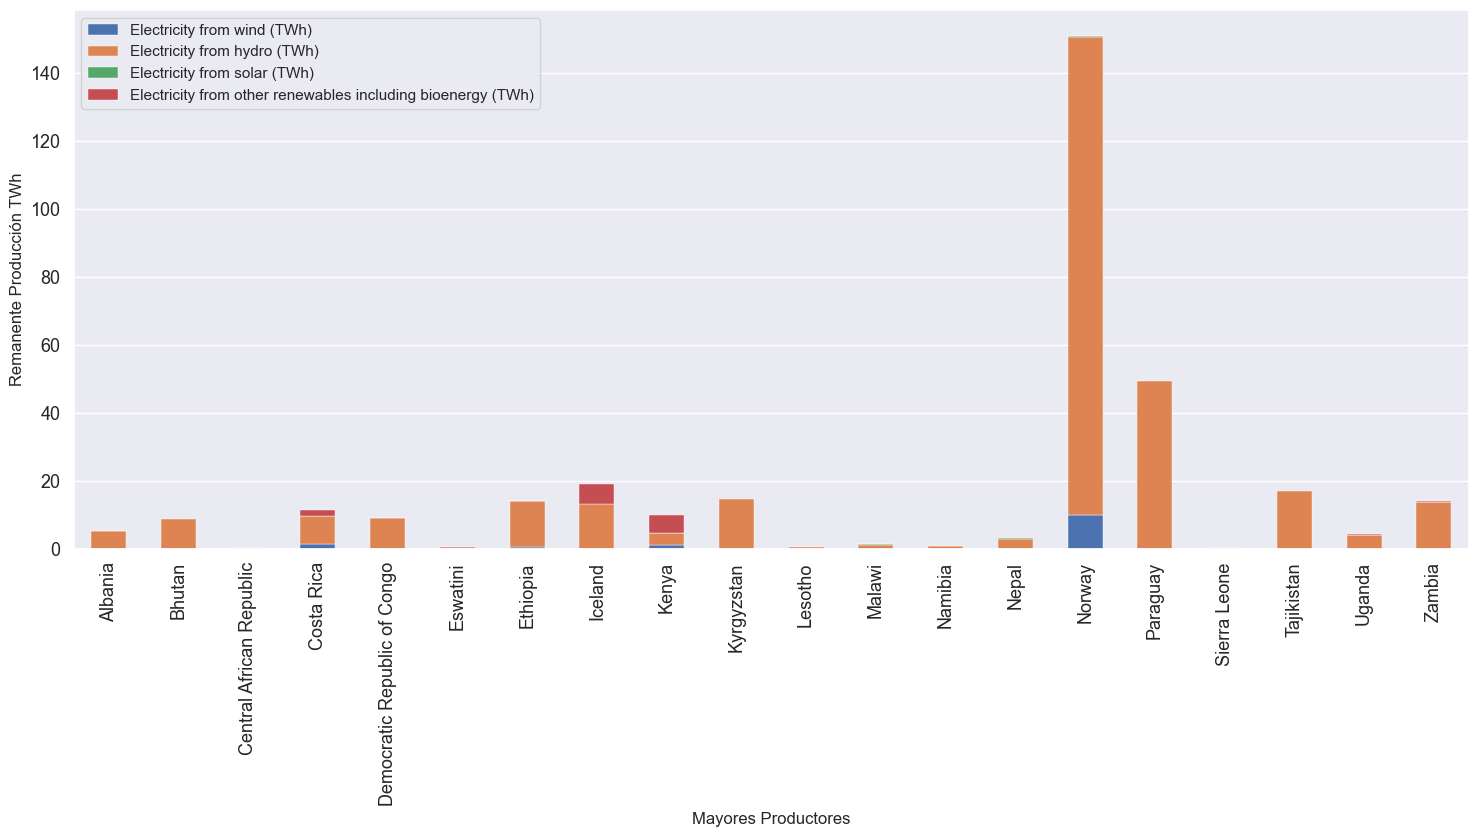

In [224]:
# Producción eléctrica total por país en términos eléctrico
share_elec20 = share_elec.loc[share_elec['Year']==2020,:]
country_list_p = share_elec20.sort_values(['Renewables (% electricity)'],ascending=False).head(20)
# Cruzamos los datos de los que más producen con sus energías renovables
prod20_all =pd.DataFrame(prod20[prod20['Entity'].isin(country_list_p['Entity'])])
# Graficamos
plt.figure(figsize=(15,10))
prod20_all.iloc[0:20].plot.bar(x='Entity',xlabel='Mayores Productores',ylabel='Remanente Producción TWh', linewidth=0.3, fontsize=13,stacked=True).grid(axis='x')

#### 5. Consumos y producciones de energía en métrica eléctrica
##### El consumo supera con bastante diferencia lo que se produce con este tipo de energías

<Figure size 1500x1000 with 0 Axes>

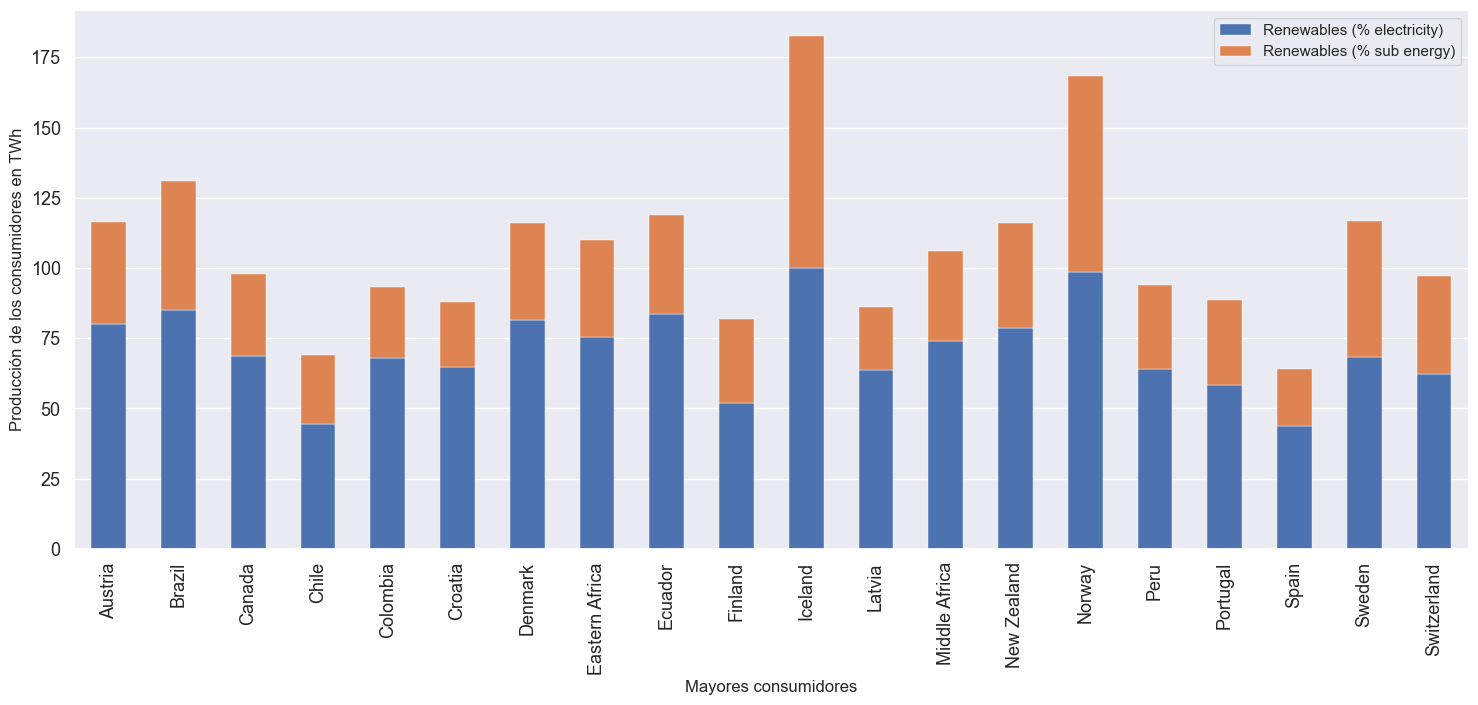

In [225]:
# Veamos la producción de electricidad de los 20 paises que más consumen
# country_list_c= lista del top 20 de paises por consumo eléctrico (métrica eléctrica)
cyp =pd.DataFrame(share_elec20[share_elec20['Entity'].isin(country_list_c['Entity'])])
# Como hemos filtrado por año y país, podemos reducir el dataframe 
cyp.drop('Year',axis=1,inplace=True)
cyp.drop('Code',axis=1,inplace=True)
country_list_c.drop('Year',axis=1,inplace=True)
country_list_c.drop('Code',axis=1,inplace=True)
# Ordenamos los paises consumidores para que podamos unir en el mismo orden con cyp
# (cyp= consumidores y productores métrica eléctrica)
country_list_c.sort_values('Entity',inplace=True)
# Tenemos un dataframe con lo que producen los que más consumen:
prod_of_cons20 = pd.merge(cyp,country_list_c, how='outer',on=['Entity'])
# Graficamos
plt.figure(figsize=(15,10))
prod_of_cons20.iloc[0:20].plot.bar(x='Entity',xlabel='Mayores consumidores',ylabel='Producción de los consumidores en TWh', linewidth=0.3, fontsize=13,stacked=True).grid(axis='x')

##### 5.1 Menores productores 

In [226]:
# Los 20 paises que menos producen.También tienen un cosumo nulo 
country_list_lessp = share_elec20.sort_values(['Renewables (% electricity)']).head(20)
# de los que menos producen, cuales consumen:
country_buy_elec =pd.DataFrame(share20[share20['Entity'].isin(country_list_lessp['Entity'])])

#### Algo que parece lógico, la mayor parte de ellos son islas

In [227]:
country_list_lessp['Entity'].unique()

array(['Macao', 'Gambia', 'Saint Pierre and Miquelon', 'Saint Lucia',
       'Botswana', 'Solomon Islands', 'British Virgin Islands',
       'Seychelles', 'Brunei', 'Oman', 'Turkmenistan', 'Palestine',
       'Djibouti', 'Turks and Caicos Islands', 'Comoros', 'Tonga',
       'Grenada', 'Nauru', 'Maldives', 'South Sudan'], dtype=object)

### 6. Proyección de futuro

#### Partiendo de antecedentes históricos, calcularemos el ranking de paises top en consumo y producción por energía
#### 6.1 Consumo

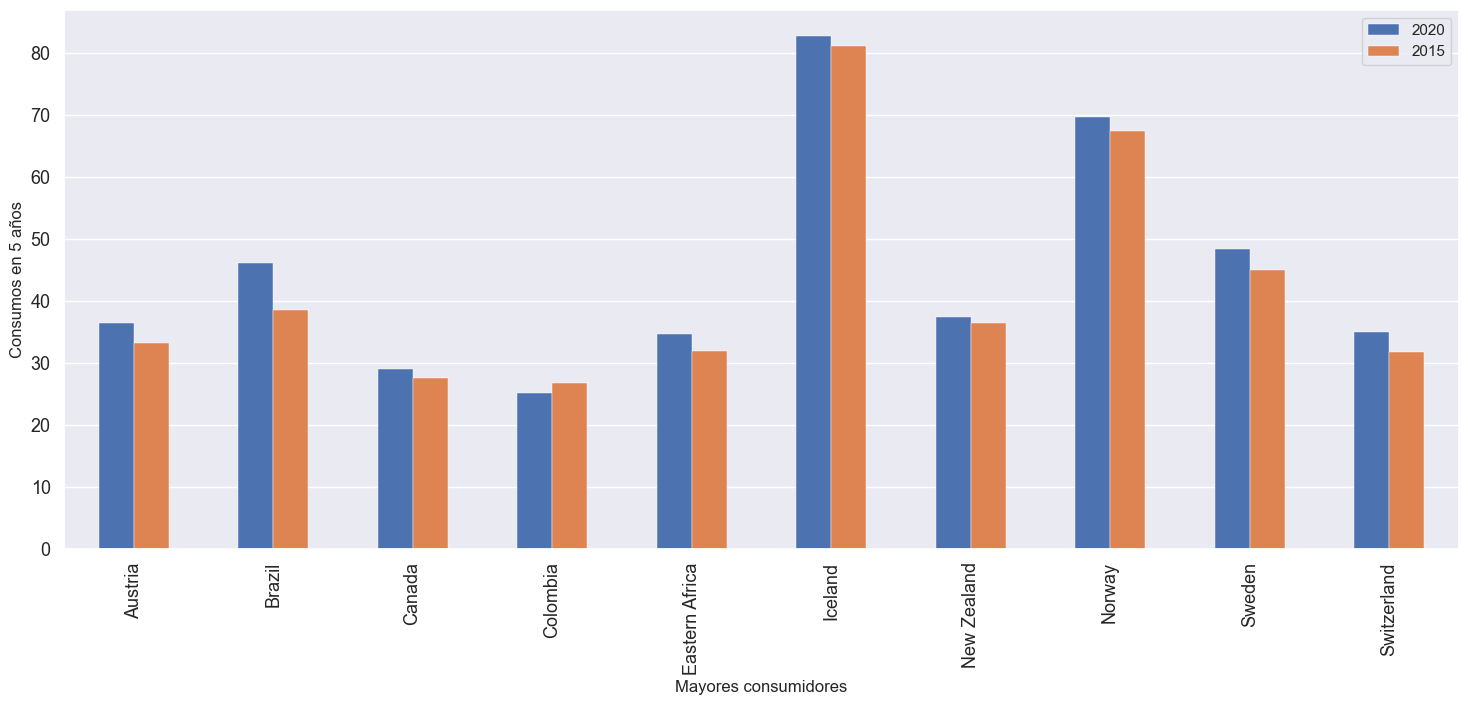

In [228]:
# Tendencia de consumo renovables en 5 años
# sube el consumo de energías renovables que están sustituyendo a las no renovables,
# excepto en Colombia (explicación en el enlace)

share2015 = share.loc[share['Year']==2015,:]
top10_cons2015 =  share2015.sort_values(['Renewables (% sub energy)'],ascending=False).head(10)
top10_cons2020 = pd.DataFrame(share20[share20['Entity'].isin(top10_cons2015['Entity'])])
top10_cons2015.sort_values(['Entity'],inplace=True)
top10_cons2020.sort_values(['Entity'],inplace=True)
top10_cons2015.drop('Year',axis=1,inplace=True)
top10_cons2015.drop('Code',axis=1,inplace=True)
top10_cons2015 = top10_cons2015.rename(columns={'Renewables (% sub energy)':'2015'})
top10_cons2020.drop('Year',axis=1,inplace=True)
top10_cons2020.drop('Code',axis=1,inplace=True)
top10_cons2020 = top10_cons2020.rename(columns={'Renewables (% sub energy)':'2020'})
cons15_20 = pd.merge(top10_cons2020,top10_cons2015, how='outer',on=['Entity'])
cons15_20.iloc[0:20].plot.bar(x='Entity',xlabel='Mayores consumidores',ylabel='Consumos en 5 años', linewidth=0.3, fontsize=13).grid(axis='x')


[El problema de Colombia](https://www.bnamericas.com/es/noticias/por-que-colombia-corre-el-riesgo-de-no-cumplir-sus-objetivos-de-energia-renovable)

#### 6.2 Producción

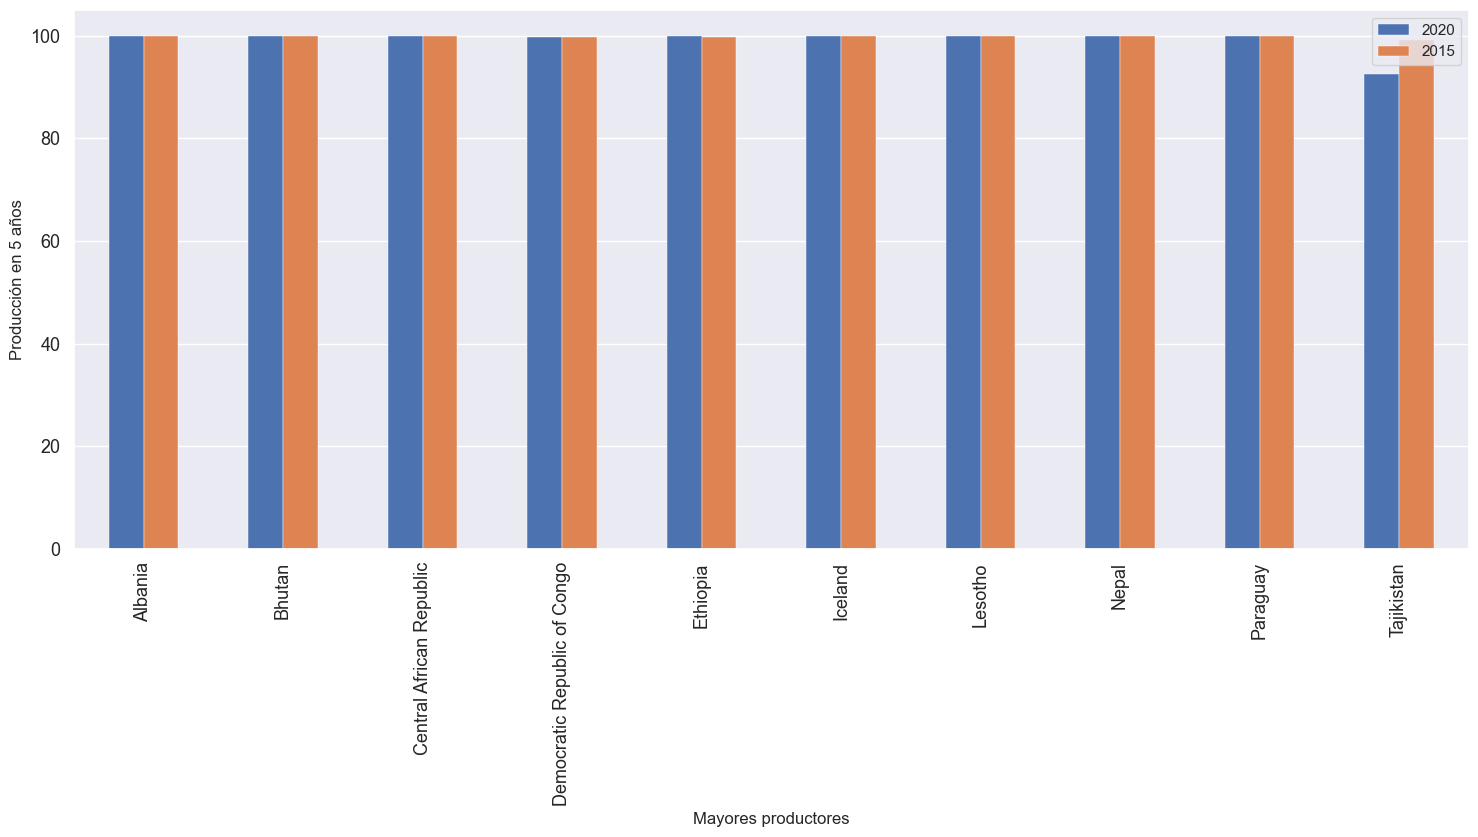

In [229]:
# Tendencia de producción de renovables en 5 años
# sube la producción de energías renovables que están sustituyendo a las no renovables
share_elec2015 = share_elec.loc[share_elec['Year']==2015,:]
top10_prod2015 =  share_elec2015.sort_values(['Renewables (% electricity)'],ascending=False).head(10)
top10_prod2020 = pd.DataFrame(share_elec20[share_elec20['Entity'].isin(top10_prod2015['Entity'])])
top10_prod2015.sort_values(['Entity'],inplace=True)
top10_prod2020.sort_values(['Entity'],inplace=True)
top10_prod2015.drop('Year',axis=1,inplace=True)
top10_prod2015.drop('Code',axis=1,inplace=True)
top10_prod2015 = top10_prod2015.rename(columns={'Renewables (% electricity)':'2015'})
top10_prod2020.drop('Year',axis=1,inplace=True)
top10_prod2020.drop('Code',axis=1,inplace=True)
top10_prod2020 = top10_prod2020.rename(columns={'Renewables (% electricity)':'2020'})
prod15_20 = pd.merge(top10_prod2020,top10_prod2015, how='outer',on=['Entity'])
prod15_20.iloc[0:20].plot.bar(x='Entity',xlabel='Mayores productores',ylabel='Producción en 5 años', linewidth=0.3, fontsize=13).grid(axis='x')
# La tendencia es la misma, veremos que el consumo de estos paises es nulo,
# pues son países en vías de desarrollo la mayoría y lo que se consume es renovable casi en su totalidad, 
# no hay industrias generadoras de energía

[Ejemplo del Congo](https://www.datosmundial.com/africa/congo-kinshasa/balance-energetico.php)

In [230]:
# Creo grafico dinámico sobre históricos
prod['Total Energy TWh'] = prod['Electricity from wind (TWh)']+prod['Electricity from hydro (TWh)']+prod['Electricity from solar (TWh)']+prod['Electricity from other renewables including bioenergy (TWh)']
map_hist= prod
map_hist= map_hist.sort_values(['Year'],ascending=True)# ordeno la línea temporal

In [231]:
# Grafico
fig = px.scatter_geo(map_hist, locations='Code',color="Total Energy TWh",
                     hover_name="Entity", size="Total Energy TWh",
                     animation_frame="Year", projection="natural earth",
                    template='plotly_dark')
fig.show()

### 7. Modelización para previsión

#### A partir de la serie temporal disponible en nuestros datasets, estudiaremos la tendencia y periodicidad, para generar un modelo predictivo.
#### Escojo las columnas que quiero estudiar

In [232]:
col_ser = ['Year','Total Energy TWh']
Total = prod[col_ser]

### No se trata de un proceso periódico, por lo que aplico los métodos para ver cuál se ajusta mejor

#### 7.1.1 Mínimos cuadrados:

In [233]:
# Agrupo por años, ya que se repiten los años por cada pais
tot_ener_prod = Total.groupby('Year').sum()

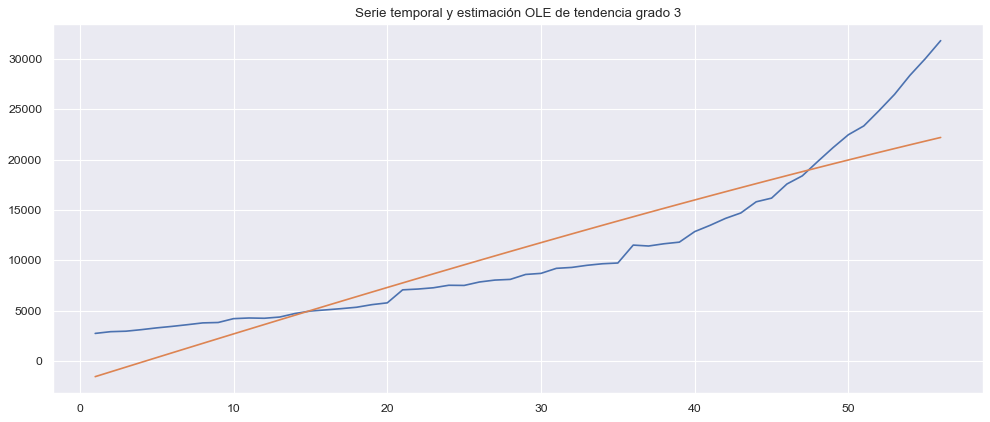

In [234]:
#Obtenemos la solución analítica por mínimos cuadrados de grado N
N = 3
time_array = np.arange(tot_ener_prod.shape[0])+1
vander_matrix = np.vander(np.arange(tot_ener_prod.shape[0])+1, N = N+1, increasing = True)
analytic_coefficients = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(vander_matrix),vander_matrix)),np.transpose(vander_matrix)),tot_ener_prod['Total Energy TWh'])
analytic_solution = np.matmul(analytic_coefficients,np.transpose(vander_matrix))
#Dibujamos la serie y su aproximación
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(time_array,tot_ener_prod['Total Energy TWh'],time_array,analytic_solution)
plt.title('Serie temporal y estimación OLE de tendencia grado {}'.format(N))
plt.show()

#### 7.1.2 Moving average
#### Observamos que la mejor es la del hiperparámetro h=5, mediante SMA (media movil simple)

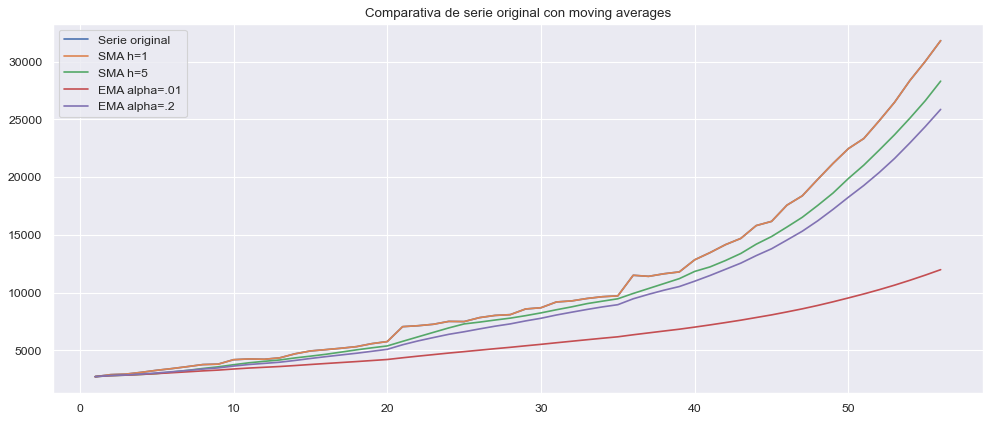

In [235]:
#Las funciones se encuentran ya implementadas en Pandas
min_periods = 1 #Hace referencia a si queremos estimar esos valores entre 1 y t-h+1 reduciendo progresivamente el valor de h
#Dibujamos
plt.figure(figsize=(15, 6), dpi=80)
plt.plot(time_array, tot_ener_prod['Total Energy TWh'], label = 'Serie original')
plt.plot(time_array, tot_ener_prod['Total Energy TWh'].rolling(window = 1, min_periods = min_periods).mean(), label = 'SMA h=1')
plt.plot(time_array, tot_ener_prod['Total Energy TWh'].rolling(window = 5, min_periods = min_periods).mean(), label = 'SMA h=5')
plt.plot(time_array, tot_ener_prod['Total Energy TWh'].ewm(alpha = .01).mean(), label = 'EMA alpha=.01')
plt.plot(time_array, tot_ener_prod['Total Energy TWh'].ewm(alpha = .2).mean(), label = 'EMA alpha=.2')
plt.title('Comparativa de serie original con moving averages')
plt.legend()
plt.show()

#### 7.1.3 Metodo de diferenciación

<AxesSubplot: xlabel='Year'>

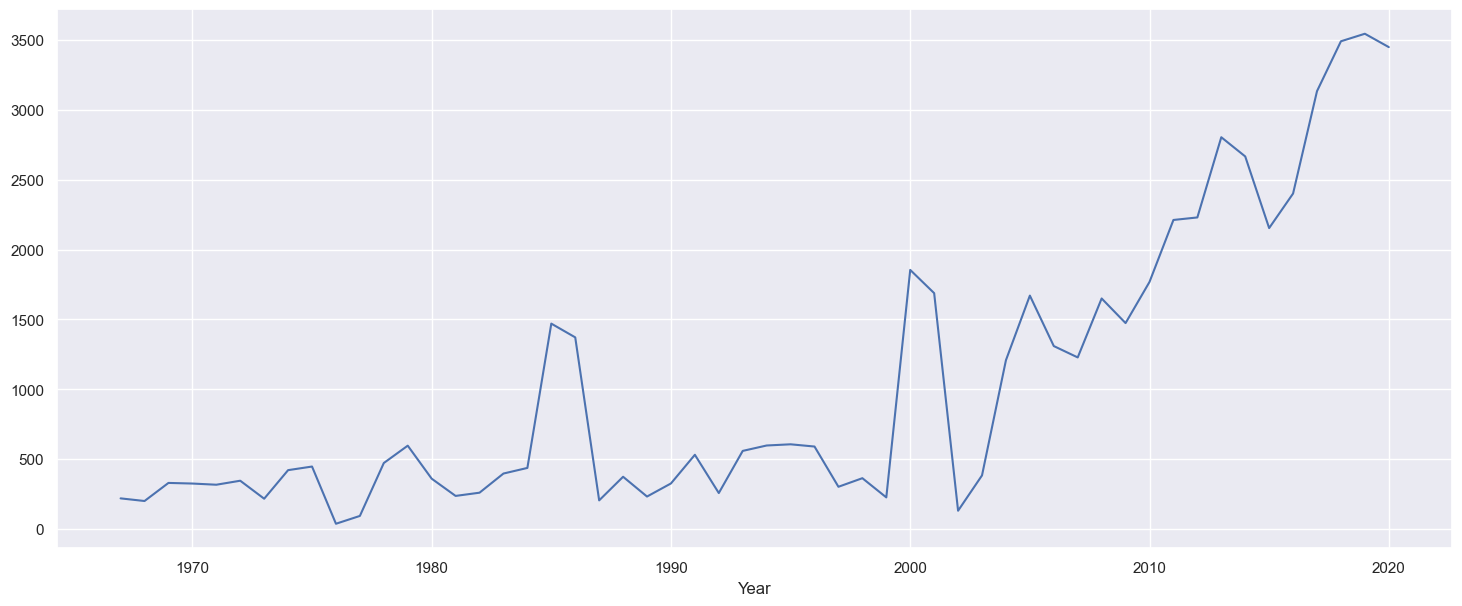

In [236]:
tot_ener_prod['Total Energy TWh'].diff(periods = 2).plot() 
# aquí vemos la diferencia entre los extremos de la 'curva'(para ver si oscilan los valores del eje 'y')

### 7.2. Aplicamos modelo autoregresivo

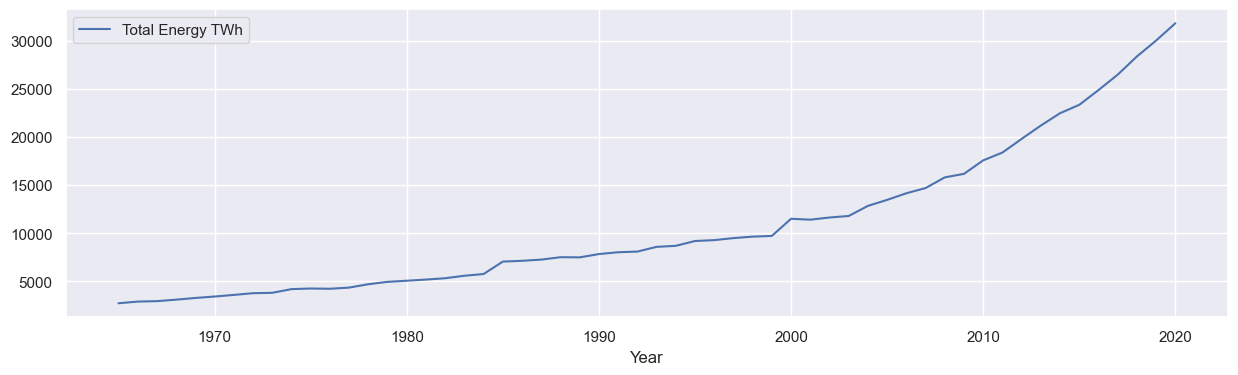

In [237]:
# Dibujamos para visualizar nuestra serie original en primer lugar
tot_ener_prod.plot(figsize=(15, 4))
plt.show()

#### Estacionariedad
#### las variaciones en mi serie no están muy correlacionadas entre sí ya que se aproximan a cero

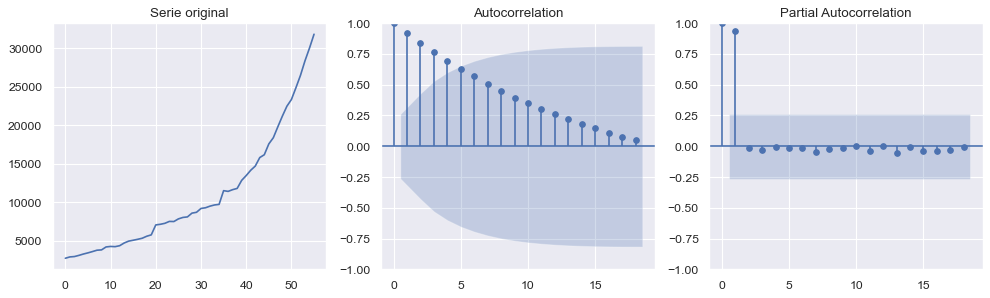

In [238]:
# A partir de la serie original
# Creamos gráfico
f = plt.figure(figsize=(15, 4), dpi=80)
# Preparamos primer componente
ax1 = f.add_subplot(131)
ax1.set_title('Serie original')
ax1.plot(tot_ener_prod['Total Energy TWh'].values)
# Preparamos segundo componente
ax2 = f.add_subplot(132)
plot_acf(tot_ener_prod['Total Energy TWh'], ax=ax2)
# Preparamos tercer componente
ax3 = f.add_subplot(133)
plot_pacf(tot_ener_prod['Total Energy TWh'].values, ax=ax3)
plt.show()

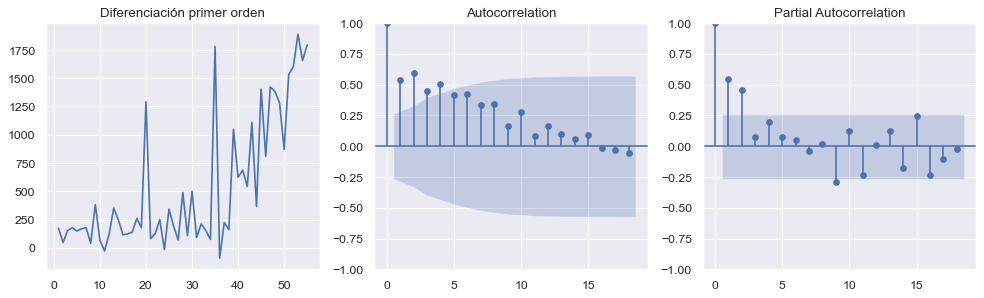

In [239]:
# Diferenciación de primer orden
# Creamos gráfico
f = plt.figure(figsize=(15, 4), dpi=80)
# Preparamos primer componente
ax1 = f.add_subplot(131)
ax1.set_title('Diferenciación primer orden')
ax1.plot(tot_ener_prod['Total Energy TWh'].diff().values)
# Preparamos segundo componente
ax2 = f.add_subplot(132)
plot_acf(tot_ener_prod['Total Energy TWh'].diff().dropna(), ax=ax2)
# Preparamos tercer componente
ax3 = f.add_subplot(133)
plot_pacf(tot_ener_prod['Total Energy TWh'].diff().dropna(), ax=ax3)
plt.show()

##### Aplicamos Dikey Fuller
Como el resultado obtenido es H0=1 tenemos tendencia estocástica en la serie temporal, y como H1=1 sólo podemos afirmar que existe una tendencia en los datos

[Explicación Dikey Fuller](https://economipedia.com/definiciones/contraste-de-dickey-fuller.html)

In [240]:
# Dikey-Fuller da valores de diferenciación extremadamente pequeños(practicamente cero a partir del orden 2, el que tomaría es el de orden 3, porque es el que más se acerca a p)
# Resultados
print(f"p-valor diferenciación orden cero: {adfuller(tot_ener_prod['Total Energy TWh'])[1]}")
print(f"p-valor diferenciación orden uno: {adfuller(tot_ener_prod['Total Energy TWh'].diff().dropna())[1]}")
print(f"p-valor diferenciación orden dos: {adfuller(tot_ener_prod['Total Energy TWh'].diff().diff().dropna())[1]}")
print(f"p-valor diferenciación orden tres: {adfuller(tot_ener_prod['Total Energy TWh'].diff().diff().diff().dropna())[1]}")
print(f"p-valor diferenciación orden cuatro: {adfuller(tot_ener_prod['Total Energy TWh'].diff().diff().diff().diff().dropna())[1]}")
print(f"p-valor diferenciación orden cinco: {adfuller(tot_ener_prod['Total Energy TWh'].diff().diff().diff().diff().diff().dropna())[1]}")

p-valor diferenciación orden cero: 1.0
p-valor diferenciación orden uno: 1.0
p-valor diferenciación orden dos: 5.824914168877411e-09
p-valor diferenciación orden tres: 3.0224723224650104e-05
p-valor diferenciación orden cuatro: 1.3623358434796543e-05
p-valor diferenciación orden cinco: 1.0269792067500325e-06


##### A partir del orden dos rechazamos la H0 por ser inferior a p, y muy próxima a cero


##### 7.3 Modelización
##### Orden autoregresivo y medias moviles

In [241]:
# Ajustamos modelo a datos
model = ARIMA(tot_ener_prod['Total Energy TWh'].values, order=(1,1,2))
model_fit = model.fit()
# Resumen del entrenamiento
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -417.285
Date:                Tue, 22 Nov 2022   AIC                            842.570
Time:                        22:24:12   BIC                            850.599
Sample:                             0   HQIC                           845.675
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9819      0.072     13.677      0.000       0.841       1.123
ma.L1         -0.7014      0.311     -2.252      0.024      -1.312      -0.091
ma.L2         -0.0646      0.312     -0.207      0.8

In [242]:
# Ajustamos modelo a datos
model = ARIMA(tot_ener_prod['Total Energy TWh'].values, order=(1,2,2))
model_fit = model.fit()
# Resumen del entrenamiento
print(model_fit.summary())
# Ha bajado de 842 a 803

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   56
Model:                 ARIMA(1, 2, 2)   Log Likelihood                -397.835
Date:                Tue, 22 Nov 2022   AIC                            803.669
Time:                        22:24:12   BIC                            811.625
Sample:                             0   HQIC                           806.738
                                 - 56                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8641      0.223     -3.878      0.000      -1.301      -0.427
ma.L1          0.0631      0.264      0.239      0.811      -0.455       0.581
ma.L2         -0.4996      0.259     -1.928      0.0

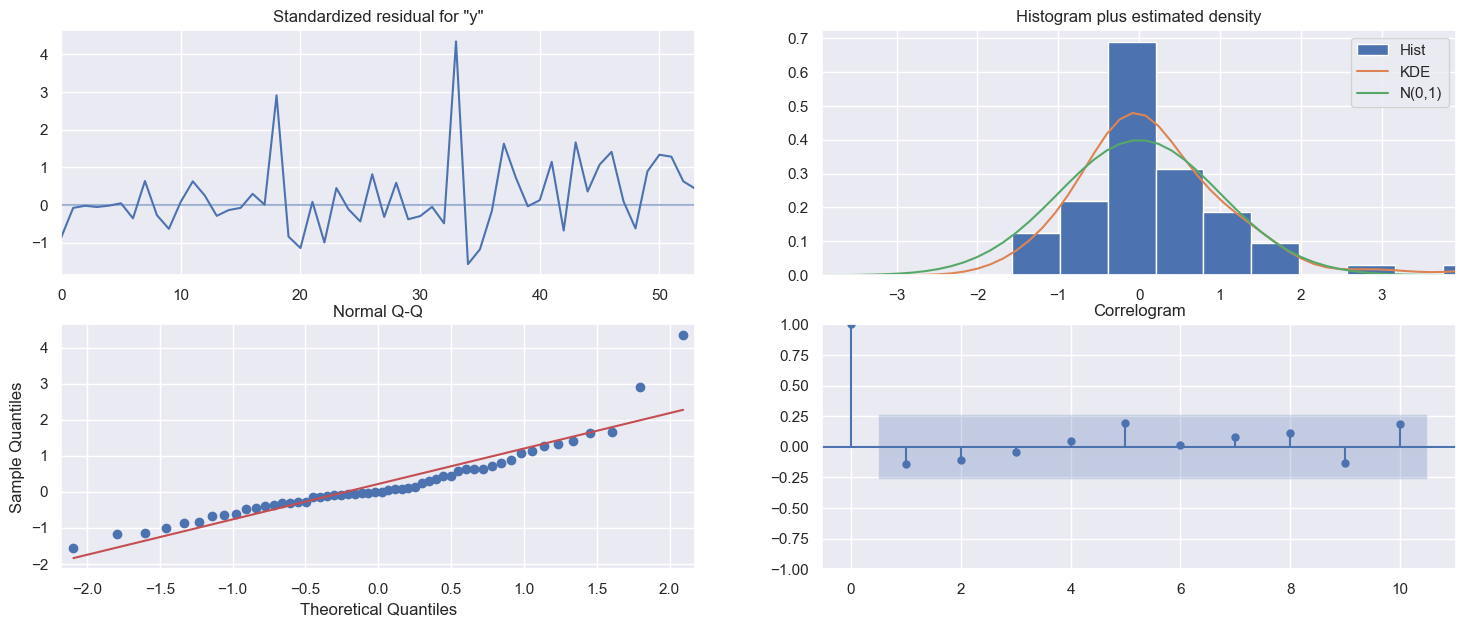

In [243]:
model_fit.plot_diagnostics()
plt.show()

#### 7.4 Predicciones y visualización

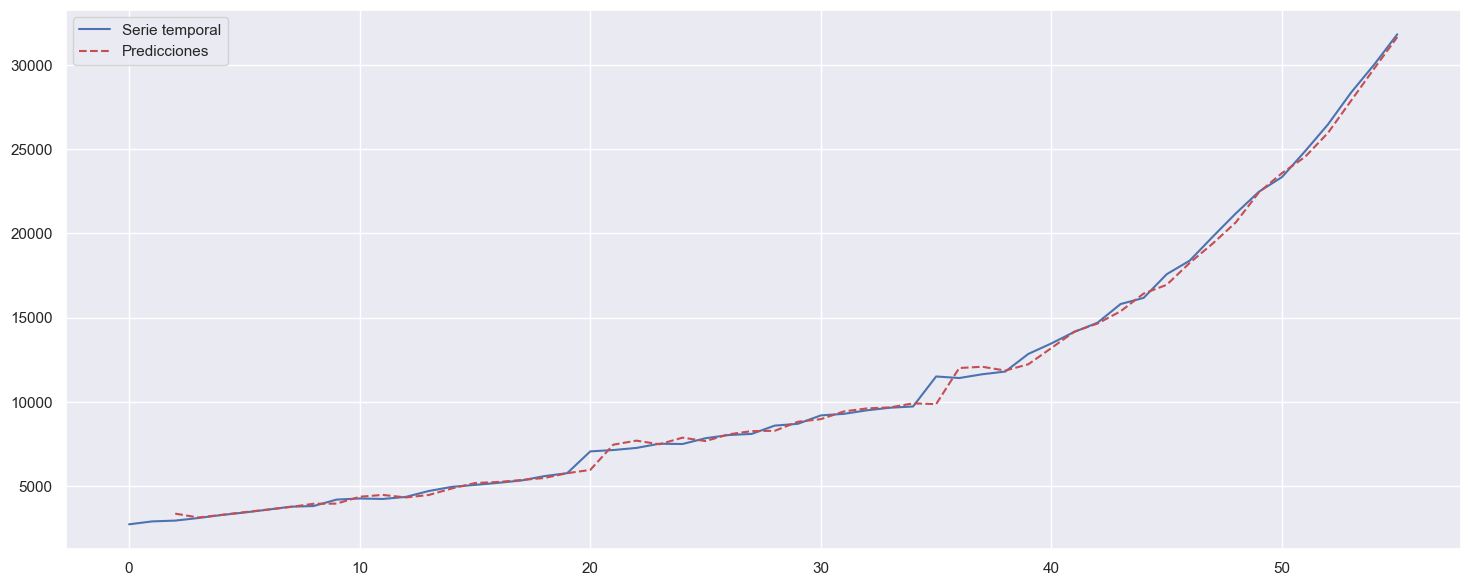

In [244]:
# Cargamos datos
series = tot_ener_prod['Total Energy TWh']
p = 1 # Coeficientes de autoregresión
d = 2 # Orden de diferenciación
q = 2 # Ajuste media móvil
# Ajustamos modelo a datos
model = ARIMA(series.values, order=(p,d,q))
model_fit = model.fit()
# Tomamos predicciones
preds = model_fit.predict()
# Creamos figura
fig, ax = plt.subplots()
ax.plot(range(len(series)), series.values, 'b-')
ax.plot(range(d,len(series)), preds[d:], 'r--')
plt.legend(['Serie temporal', 'Predicciones'])
plt.show()
# este tipo de aproximación es más picuda que el orignal

Predicho=11870.675141, Valor real=11414.033000
Predicho=11597.449167, Valor real=11637.644000
Predicho=11944.641314, Valor real=11798.066000
Predicho=11982.728033, Valor real=12846.204000
Predicho=13053.125591, Valor real=13469.081000
Predicho=13794.659235, Valor real=14156.019000
Predicho=14620.461903, Valor real=14697.535000
Predicho=15265.574581, Valor real=15806.446000
Predicho=16397.768932, Valor real=16171.778000
Predicho=16913.172279, Valor real=17575.280000
Predicho=18266.531117, Valor real=18384.146000
Predicho=19249.153808, Valor real=19805.720000
Predicho=20581.384217, Valor real=21188.616000
Predicho=22222.452601, Valor real=22472.769000
Predicho=23709.755791, Valor real=23342.830000
Predicho=24490.199958, Valor real=24874.319000
Predicho=26231.505891, Valor real=26477.024000
Predicho=27867.087205, Valor real=28365.623000
Predicho=29759.595423, Valor real=30022.228000
Predicho=31639.239933, Valor real=31815.245000
Test RMSE: 20.475


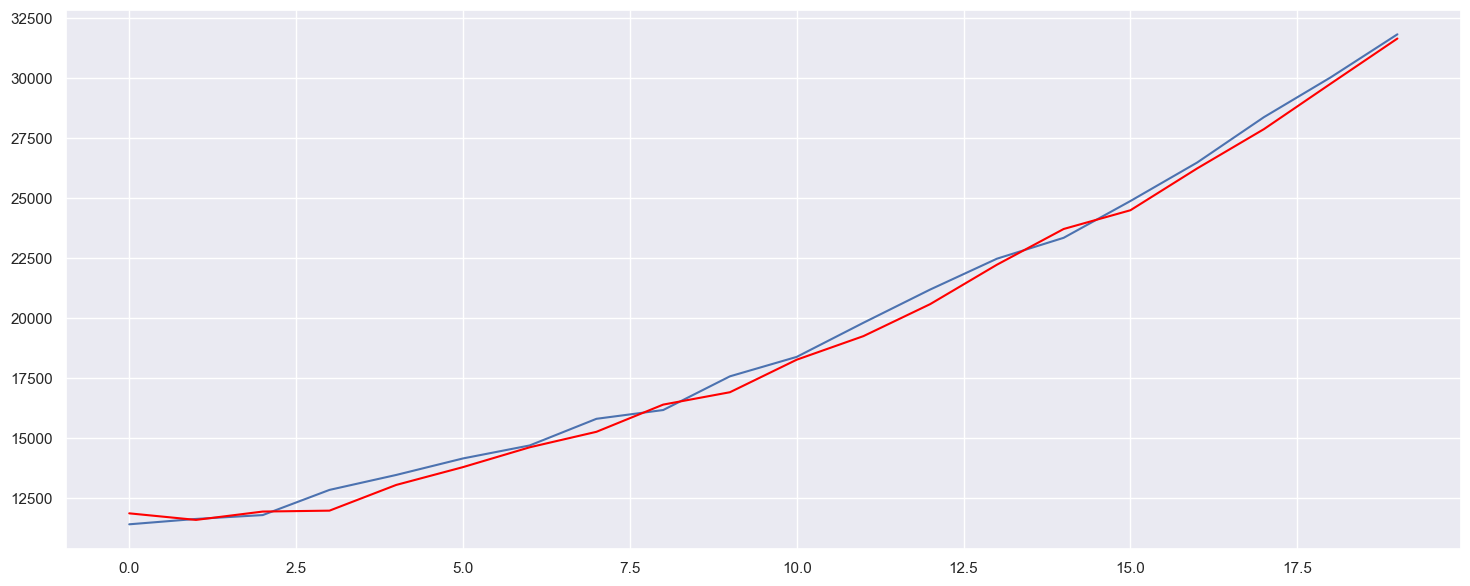

In [247]:
# Partimos datos para asegurar una validación final
# en datos test
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
# Walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(1,2,2))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('Predicho=%f, Valor real=%f' % (yhat, obs))
# Evaluamos los resultados
metric = lambda x,y : np.sqrt(np.mean((x-y)**2))
rmse = np.sqrt(metric(test, predictions))
print('Test RMSE: %.3f' % rmse)
# Dibujamos valor real y predicho
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

#### Previsión

In [246]:
p = 3 # Coeficientes de autoregresión
d = 2 # Orden de diferenciación
q = 1 # Ajuste media móvil
n = 5 # número de predicciones
todo=series.values

for _ in range(n):
    model = ARIMA(todo, order=(p,d,q))
    model_fit = model.fit()
    preds = model_fit.predict()
    todo = np.append(todo, model_fit.forecast()[0], axis=None)
    preds = np.append(preds, model_fit.forecast()[0], axis=None)


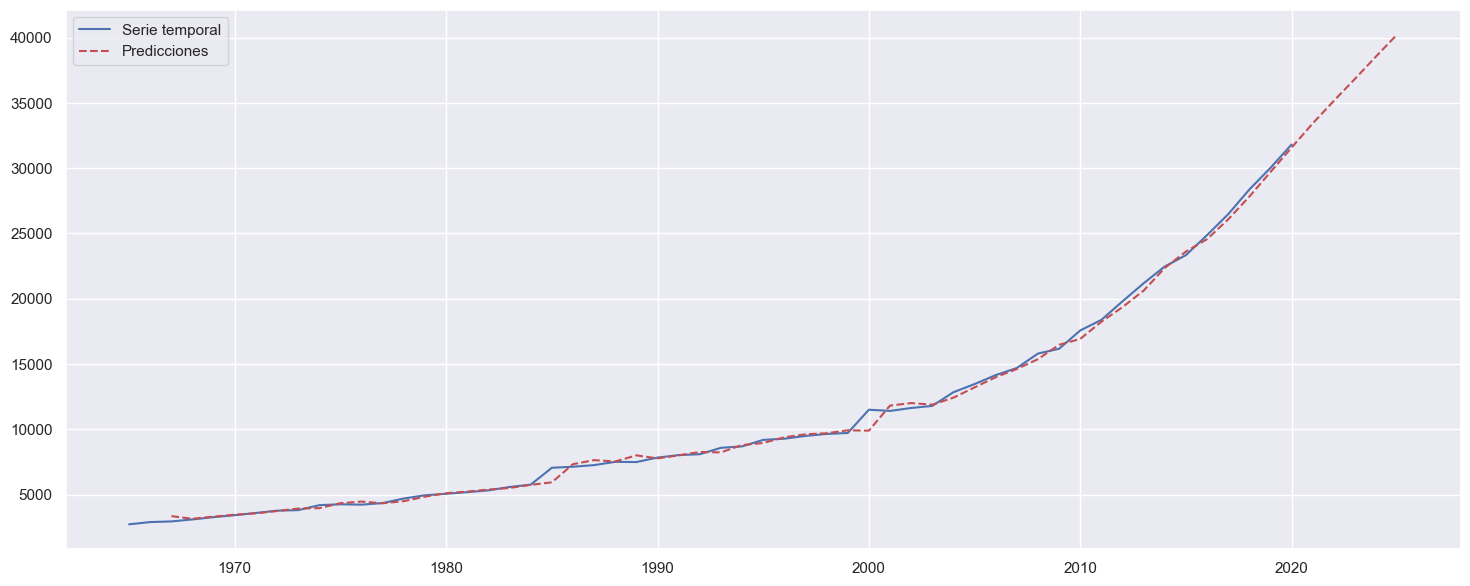

In [149]:
# Asi ponemos los años en el eje

fig, ax = plt.subplots()
ax.plot([x+1965 for x in range(len(series))], series.values, 'b-')
ax.plot([x+1965 for x in range(d,len(series)+n)], preds[d:], 'r--')
plt.legend(['Serie temporal', 'Predicciones'])
plt.show()

#### Fuentes consultadas y agradecimientos:

* https://www.kaggle.com/datasets/programmerrdai/renewable-energy
* https://www.bp.com/en/global/corporate/energy-economics/statistical-review-of-world-energy.html
* https://datos.canarias.es/catalogos/estadisticas/dataset/paises-del-mundo-en-2016-delimitaciones-territoriales-para-fines-estadisticos-en-canarias/resource/36c79c62-04af-4fbf-88a7-2764303ae61c?view_id=3be1ecf6-7a7f-4c11-a51a-ec554ab5d24a
* https://www.youtube.com/watch?v=uXj76K9Lnqc&t=1349s
* https://github.com/ruchitaj2/UCI-BlogFeedback-Data-Set/blob/master/BlogFeed%20Data%20Set.ipynb
* https://github.com/albertyw/avenews/blob/master/old/data/average-latitude-longitude-countries.csv
* https://levelup.gitconnected.com/how-to-add-a-background-image-to-your-streamlit-app-96001e0377b2
* https://joserzapata.github.io/courses/python-ciencia-datos/visualizacion/

Imágenes:
* https://www.adslzone.net/noticias/tecnologia/metodos-alternativos-energia-solar-energias-renovables/
* https://www.youtube.com/watch?v=4mAWW8kH4-A
* https://twenergy.com/ecologia-y-reciclaje/medio-ambiente/honduras-ya-genera-el-60-de-su-energia-a-traves-de-fuentes-renovables-2672/

Agradecimientos:

- Zakaria Chowdhury ; por sus tutoriales y respuestas en distintas plataformas
- Profesores Bootcamp ; principalmente a los 3 que nos han dedicado su tiempo,por proveernos de las herramientas necesarias para comenzar en el mundo del análisis de data, y por tratar de ayudarnos.

##############################################################################################################################################################################################################################################################

#### Anexo

#### Codigo empleado para Streamlit

#### Preciso crear un dataframe nuevo con países en inglés y sus coordenadas para su representación

In [94]:
# # Me creo mi dataframe de coordenadas y paises en inglés para poder asociar sus coordenadas a mi df
# lst = [["AD","Andorra",42.5,1.5],["AE","United Arab Emirates",24,54],["AF","Afghanistan",33,65],["AG","Antigua and Barbuda",17.05,-61.8],["AI","Anguilla",18.25,-63.17],["AL","Albania",41,20],["AM","Armenia",40,45],["AN","Netherlands Antilles",12.25,-68.75],["AO","Angola",-12.5,18.5],["AP","Asia/Pacific Region",35,105],["AQ","Antarctica",-90,0],["AR","Argentina",-34,-64],["AS","American Samoa",-14.33,-170],["AT","Austria",47.33,13.33],["AU","Australia",-27,133],["AW","Aruba",12.5,-69.97],["AZ","Azerbaijan",40.5,47.5],["BA","Bosnia and Herzegovina",44,18],["BB","Barbados",13.17,-59.53],["BD","Bangladesh",24,90],["BE","Belgium",50.83,4],["BF","Burkina Faso",13,-2],["BG","Bulgaria",43,25],["BH","Bahrain",26,50.55],["BI","Burundi",-3.5,30],["BJ","Benin",9.5,2.25],["BM","Bermuda",32.33,-64.75],["BN","Brunei Darussalam",4.5,114.67],["BO","Bolivia",-17,-65],["BR","Brazil",-10,-55],["BS","Bahamas",24.25,-76],["BT","Bhutan",27.5,90.5],["BV","Bouvet Island",-54.43,3.4],["BW","Botswana",-22,24],["BY","Belarus",53,28],["BZ","Belize",17.25,-88.75],["CA","Canada",60,-95],["CC","Cocos (Keeling) Islands",-12.5,96.83],["CD","Congo, The Democratic Republic of the",0,25],["CF","Central African Republic",7,21],["CG","Congo",-1,15],["CH","Switzerland",47,8],["CI","Cote d'Ivoire",8,-5],["CK","Cook Islands",-21.23,-159.77],["CL","Chile",-30,-71],["CM","Cameroon",6,12],["CN","China",35,105],["CO","Colombia",4,-72],["CR","Costa Rica",10,-84],["CU","Cuba",21.5,-80],["CV","Cape Verde",16,-24],["CX","Christmas Island",-10.5,105.67],["CY","Cyprus",35,33],["CZ","Czech Republic",49.75,15.5],["DE","Germany",51,9],["DJ","Djibouti",11.5,43],["DK","Denmark",56,10],["DM","Dominica",15.42,-61.33],["DO","Dominican Republic",19,-70.67],["DZ","Algeria",28,3],["EC","Ecuador",-2,-77.5],["EE","Estonia",59,26],["EG","Egypt",27,30],["EH","Western Sahara",24.5,-13],["ER","Eritrea",15,39],["ES","Spain",40,-4],["ET","Ethiopia",8,38],["EU","Europe",47,8],["FI","Finland",64,26],["FJ","Fiji",-18,175],["FK","Falkland Islands (Malvinas)",-51.75,-59],["FM","Micronesia, Federated States of",6.92,158.25],["FO","Faroe Islands",62,-7],["FR","France",46,2],["GA","Gabon",-1,11.75],["GB","United Kingdom",54,-2],["GD","Grenada",12.12,-61.67],["GE","Georgia",42,43.5],["GF","French Guiana",4,-53],["GH","Ghana",8,-2],["GI","Gibraltar",36.18,-5.37],["GL","Greenland",72,-40],["GM","Gambia",13.47,-16.57],["GN","Guinea",11,-10],["GP","Guadeloupe",16.25,-61.58],["GQ","Equatorial Guinea",2,10],["GR","Greece",39,22],["GS","South Georgia and the South Sandwich Islands",-54.5,-37],["GT","Guatemala",15.5,-90.25],["GU","Guam",13.47,144.78],["GW","Guinea-Bissau",12,-15],["GY","Guyana",5,-59],["HK","Hong Kong",22.25,114.17],["HM","Heard Island and McDonald Islands",-53.1,72.52],["HN","Honduras",15,-86.5],["HR","Croatia",45.17,15.5],["HT","Haiti",19,-72.42],["HU","Hungary",47,20],["ID","Indonesia",-5,120],["IE","Ireland",53,-8],["IL","Israel",31.5,34.75],["IN","India",20,77],["IO","British Indian Ocean Territory",-6,71.5],["IQ","Iraq",33,44],["IR","Iran, Islamic Republic of",32,53],["IS","Iceland",65,-18],["IT","Italy",42.83,12.83],["JM","Jamaica",18.25,-77.5],["JO","Jordan",31,36],["JP","Japan",36,138],["KE","Kenya",1,38],["KG","Kyrgyzstan",41,75],["KH","Cambodia",13,105],["KI","Kiribati",1.42,173],["KM","Comoros",-12.17,44.25],["KN","Saint Kitts and Nevis",17.33,-62.75],["KP","Korea, Democratic People's Republic of",40,127],["KR","Korea, Republic of",37,127.5],["KW","Kuwait",29.34,47.66],["KY","Cayman Islands",19.5,-80.5],["KZ","Kazakhstan",48,68],["LA","Lao People's Democratic Republic",18,105],["LB","Lebanon",33.83,35.83],["LC","Saint Lucia",13.88,-61.13],["LI","Liechtenstein",47.17,9.53],["LK","Sri Lanka",7,81],["LR","Liberia",6.5,-9.5],["LS","Lesotho",-29.5,28.5],["LT","Lithuania",56,24],["LU","Luxembourg",49.75,6.17],["LV","Latvia",57,25],["LY","Libyan Arab Jamahiriya",25,17],["MA","Morocco",32,-5],["MC","Monaco",43.73,7.4],["MD","Moldova, Republic of",47,29],["ME","Montenegro",42,19],["MG","Madagascar",-20,47],["MH","Marshall Islands",9,168],["MK","Macedonia",41.83,22],["ML","Mali",17,-4],["MM","Myanmar",22,98],["MN","Mongolia",46,105],["MO","Macao",22.17,113.55],["MP","Northern Mariana Islands",15.2,145.75],["MQ","Martinique",14.67,-61],["MR","Mauritania",20,-12],["MS","Montserrat",16.75,-62.2],["MT","Malta",35.83,14.58],["MU","Mauritius",-20.28,57.55],["MV","Maldives",3.25,73],["MW","Malawi",-13.5,34],["MX","Mexico",23,-102],["MY","Malaysia",2.5,112.5],["MZ","Mozambique",-18.25,35],["NA","Namibia",-22,17],["NC","New Caledonia",-21.5,165.5],["NE","Niger",16,8],["NF","Norfolk Island",-29.03,167.95],["NG","Nigeria",10,8],["NI","Nicaragua",13,-85],["NL","Netherlands",52.5,5.75],["NO","Norway",62,10],["NP","Nepal",28,84],["NR","Nauru",-0.53,166.92],["NU","Niue",-19.03,-169.87],["NZ","New Zealand",-41,174],["OM","Oman",21,57],["PA","Panama",9,-80],["PE","Peru",-10,-76],["PF","French Polynesia",-15,-140],["PG","Papua New Guinea",-6,147],["PH","Philippines",13,122],["PK","Pakistan",30,70],["PL","Poland",52,20],["PM","Saint Pierre and Miquelon",46.83,-56.33],["PR","Puerto Rico",18.25,-66.5],["PS","Palestinian Territory",32,35.25],["PT","Portugal",39.5,-8],["PW","Palau",7.5,134.5],["PY","Paraguay",-23,-58],["QA","Qatar",25.5,51.25],["RE","Reunion",-21.1,55.6],["RO","Romania",46,25],["RS","Serbia",44,21],["RU","Russian Federation",60,100],["RW","Rwanda",-2,30],["SA","Saudi Arabia",25,45],["SB","Solomon Islands",-8,159],["SC","Seychelles",-4.58,55.67],["SD","Sudan",15,30],["SE","Sweden",62,15],["SG","Singapore",1.37,103.8],["SH","Saint Helena",-15.93,-5.7],["SI","Slovenia",46,15],["SJ","Svalbard and Jan Mayen",78,20],["SK","Slovakia",48.67,19.5],["SL","Sierra Leone",8.5,-11.5],["SM","San Marino",43.77,12.42],["SN","Senegal",14,-14],["SO","Somalia",10,49],["SR","Suriname",4,-56],["ST","Sao Tome and Principe",1,7],["SV","El Salvador",13.83,-88.92],["SY","Syrian Arab Republic",35,38],["SZ","Swaziland",-26.5,31.5],["TC","Turks and Caicos Islands",21.75,-71.58],["TD","Chad",15,19],["TF","French Southern Territories",-43,67],["TG","Togo",8,1.17],["TH","Thailand",15,100],["TJ","Tajikistan",39,71],["TK","Tokelau",-9,-172],["TM","Turkmenistan",40,60],["TN","Tunisia",34,9],["TO","Tonga",-20,-175],["TR","Turkey",39,35],["TV","Tuvalu",-8,178],["TW","Taiwan",23.5,121],["TZ","Tanzania, United Republic of",-6,35],["UA","Ukraine",49,32],["UG","Uganda",1,32],["UM","United States Minor Outlying Islands",19.28,166.6],["US","United States",38,-97],["UY","Uruguay",-33,-56],["UZ","Uzbekistan",41,64],["VA","Holy See (Vatican City State)",41.9,12.45],["VC","Saint Vincent and the Grenadines",13.25,-61.2],["VE","Venezuela",8,-66],["VG","Virgin Islands, British",18.5,-64.5],["VI","Virgin Islands, U.S.",18.33,-64.83],["VN","Vietnam",16,106],["VU","Vanuatu",-16,167],["WF","Wallis and Futuna",-13.3,-176.2],["WS","Samoa",-13.58,-172.33],["YE","Yemen",15,48],["YT","Mayotte",-12.83,45.17],["ZA","South Africa",-29,24],["ZM","Zambia",-15,30],["ZW","Zimbabwe",-20,30]]
# df_coor_countries = pd.DataFrame(lst, columns =["ISO 3166 Country Code", "Country", "Latitude","Longitude"], dtype = float) 

In [97]:
# # Añado las columnas a rellenar Latitud y Longitud
# column_names=['Entity', 'Code', 'Year', 'Electricity from wind (TWh)',
#        'Electricity from hydro (TWh)', 'Electricity from solar (TWh)',
#        'Electricity from other renewables including bioenergy (TWh)', 'Total Energy TWh', 'Latitude', 'Longitude']

# prod = prod.reindex(columns = column_names)

In [107]:
# # PUEDE TARDAR 6 o 7 min!!

# i=0
# j=0
# latitud = prod['Latitude']
# longitud = prod['Longitude']
# Latitude = df_coor_countries['Latitude']
# Longitude = df_coor_countries['Longitude']

# for i in range(len(prod)):
#     for j in range(len(df_coor_countries)):
#         if (prod.loc[i]['Entity']) == (df_coor_countries.loc[j]['Country']):
#             latitud[i] = Latitude[j]
#             longitud[i] = Longitude[j]
#         else:
#             continue
     

#### Exporto csv para evitarme preprocesamiento y cargas de datasets más pesados

In [152]:
#Lo paso para poder usarlo desde Streamlit
prod.to_csv('prod.csv')
cons20_all.to_csv('cons20_all.csv')
prod20_all.to_csv('prod20_all.csv')
prod_of_cons20.to_csv('prod_of_cons20.csv')
cons15_20.to_csv('cons15_20.csv')
map_hist.to_csv('map_hist.csv')


### Código empleado para variar tamaño de las imágenes empleadas

In [4]:
# # Cambio tamaño imagenes
# import cv2

# imagen = cv2.imread('energias-renovables-alternativa-solar.jpg')
# (alto,ancho,canales)= imagen.shape
# print('Alto={}, Ancho={}, Canales={}'.format(alto,ancho,canales))
# #me devuelve las dimensiones de la imagen

# # # Redimensionamiento bruto
# # redim=cv2.resize(imagen,(200,200))

# # Redimensionamiento proporcional
# r = 300/ancho
# dim = (664, int(alto*r))
# redimp = cv2.resize(imagen, dim)

# cv2.imshow('Imagen',redimp)
# cv2.waitKey(0)

Alto=664, Ancho=1268, Canales=3


-1